In [24]:
import pandas as pd
import numpy as np
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot as plt

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
date = df['date'].tail(391-44)
deaths = df['deathIncrease'].tail(391-44)
sequence=list(deaths)

In [12]:
def split_sequence(data,steps_in,steps_out):
    X,y=list(),list()
    for i in range(len(data)):
        seq_end=i+steps_in
        end_out=seq_end+steps_out
        if end_out > len(data):
            break
        seq_x, seq_y=data[i:seq_end], data[seq_end:end_out]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

In [13]:
steps_in, steps_out = 5 , 1
X, y=split_sequence(sequence,steps_in,steps_out)

In [37]:
features=1
X=X.reshape(X.shape[0],X.shape[1],features)
print(X.shape, y.shape)

(342, 5, 1) (342, 1)


In [42]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(steps_in, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(steps_out))
model.add(GRU(96,activation='relu'))
model.add(RepeatVector(steps_out))
model.add(GRU(180, activation='relu'))
#model.add(RepeatVector(steps_out))
#model.add(GRU(224, activation='relu'))
model.add(Dense(steps_out))
model.compile(optimizer='adam',loss='mape')

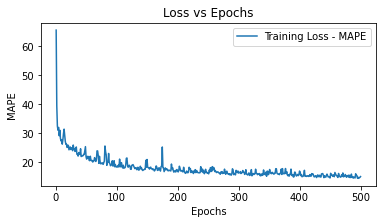

Min Training Loss = 14.439645767211914 at Epoch 497


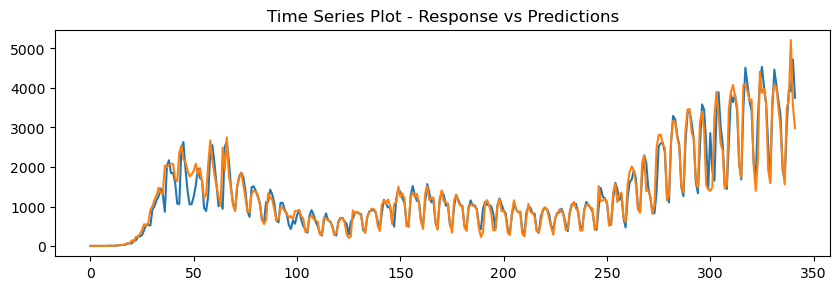

In [43]:
fit_history = model.fit(X, y, epochs=500, batch_size=20,verbose=0)
plotHistory(fit_history,"MAPE")
yp = pd.DataFrame(model.predict(X,batch_size=100))
hr = 1
y=y.reshape(342,1)
plt.figure(num=0, figsize=(10,3),dpi=100)
plt.plot(yp.iloc[:,hr-1])
plt.plot(y[:,hr-1])
plt.title("Time Series Plot - Response vs Predictions")
plt.show()

In [7]:
def plotHistory(fit_history,ls="MAPE"):
    #Get training loss
    loss = fit_history.history['loss']
    # val_loss = fit_history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(loss) + 1)

#     # Visualize loss history - Plotting Loss vs Number of Epochs during training
    plt.figure(num=0,figsize=(6,3))
    plt.plot(epoch_count, loss)
    # plt.plot(val_loss)
    plt.legend(['Training Loss - '+str(ls), 'Validation Loss - '+str(ls)])
    plt.xlabel('Epochs')
    plt.ylabel(ls)
    plt.title("Loss vs Epochs")
    plt.show()

#     print("_________________________________________________________________________________________")
    print("Min Training Loss = " + str(np.min(loss)) + " ",end='')
    print("at Epoch " + str(np.argmin(loss) + 1))
    # print("Min Validation Loss = " + str(np.min(val_loss)) + " ",end='')
    # print("at Epoch " + str(np.argmin(val_loss) + 1))
#     print("__________________________________________________________________________________________")

In [8]:
def eval(y,yp):
    # print(y)
    # print(yp)
    import math
    roundTo = 5
    m = y.shape[0]
    # print(m)
    e = y - yp
    # print("m")
    # print(e)
    yt = y - y.mean()
    sse = e.dot(e)
    sst = yt.dot(yt)
    rSq = round((1 - ((sse)/(sst))),roundTo)
    mape = round(((np.absolute(e)/np.absolute(y)).sum())*100/m,roundTo)
    t = (np.absolute(e)/(np.absolute(y)+np.absolute(yp)))
    print(t.sum()*200/m)
    smape = round(((np.absolute(e)/(np.absolute(y)+np.absolute(yp))).sum())*200/m,roundTo)
    # smape  = 200 * (e.abs / (yy.abs + yp.abs)).sum / m
    mse = round((sse/m),roundTo)
    rmse = round(math.sqrt(mse),roundTo)
#     return(rSq,mape,mse,rmse,sse,sst)
    return(format(rSq,'.4f'),format(mape,'.2f'),format(smape,'.2f'),format(mse,'.2f'),format(rmse,'.2f'),format(sse,'.2f'),format(sst,'.2f'))